<a href="https://colab.research.google.com/github/CostaNathan/doctorate/blob/Modelos-de-dispers%C3%A3o-e-qualidade-da-%C3%A1gua/modelando_tudo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ideia central

- Começar a modelar de forma "simples", para, posteriormente, iniciar o processo de modificação das equações, transformando os sistemas de equações em um modelo mais robusto, com maior representabilidade da realidade.

## Trabalhinho citado pela Cynara que contém algumas equações interessantes (a partir da p. 58:

https://sarasota.wateratlas.usf.edu/upload/documents/ModelImpactNutrLoadReductionWQSeagrass_Sheng1995.pdf

# Resolvendo o odeint com constantes que mudam a cada passo de tempo. Abaixo, o exemplo:

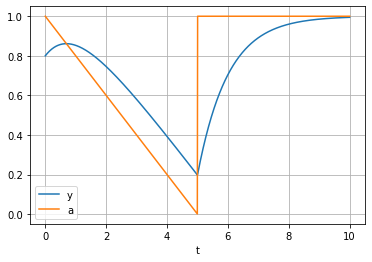

In [1]:
# https://stackoverflow.com/questions/32987253/solving-a-system-of-odes-with-changing-constant-using-scipy-integrate-odeint

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate

tmax = 10.0


def a(t):
    if t < tmax / 2.0:
        return ((tmax / 2.0) - t) / (tmax / 2.0)
    else:
        return 1.0


def func(x, t, a):
    return -(x - a(t))


x0 = 0.8
t = np.linspace(0.0, tmax, 1000)
args = (a,)
y = sp.integrate.odeint(func, x0, t, args)

fig = plt.figure()
ax = fig.add_subplot(111)
(h1,) = ax.plot(t, y)
(h2,) = ax.plot(t, [a(s) for s in t])
ax.legend([h1, h2], ["y", "a"])
ax.set_xlabel("t")
ax.grid()
plt.show()


# Mais um exemplo:

24 23 23


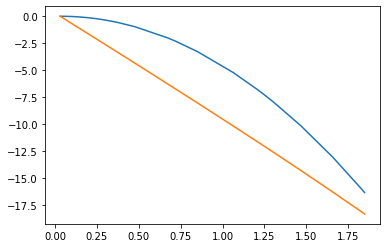

In [2]:
# https://stackoverflow.com/questions/35586452/how-to-pass-more-data-into-scipy-integrate-odeint

import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d


def dr_dt(y, t, fint):

    RHO = 1225.0
    C_D = 0.75
    A = 6.25e-4
    G = 9.81
    M_O = 100.0
    M_P = 10.8
    M_F = M_O - M_P
    T = 1.86

    M_E = (M_O - M_F) / T

    dy0 = y[1]
    dy1 = (
        (fint(t) / (M_O - M_E * t))
        - ((1.0 * RHO * C_D * A * y[1] ** 2) / (2.0 * (M_O - M_E * t)))
        - G
    )
    return dy0, dy1


t = np.array(
    [
        0.031,
        0.092,
        0.139,
        0.192,
        0.209,
        0.231,
        0.248,
        0.292,
        0.370,
        0.475,
        0.671,
        0.702,
        0.723,
        0.850,
        1.063,
        1.211,
        1.242,
        1.303,
        1.468,
        1.656,
        1.821,
        1.834,
        1.847,
        1.860,
    ]
)
f = np.array(
    [
        0.946,
        4.826,
        9.936,
        14.090,
        11.446,
        7.381,
        6.151,
        5.489,
        4.921,
        4.448,
        4.258,
        4.542,
        4.164,
        4.448,
        4.353,
        4.353,
        4.069,
        4.258,
        4.353,
        4.448,
        4.448,
        2.933,
        1.325,
        0.000,
    ]
)

r_o = 0.0
v_o = 0.0

fint = interp1d(t, f)
y = odeint(dr_dt, [r_o, v_o], t[:-1], args=(fint,))

a = y[:, 0]
b = y[:, 1]

print(len(t), len(a), len(b))

# Necessário omitir o último passo de tempo
plt.plot(t[:-1], a)
plt.plot(t[:-1], b)
plt.show()


# OD-DBO

- Irei iniciar a modelagem utilizando algo pronto, das eqs. que o modelo de Streeter-Phelps utiliza para a solução analítica do problema.

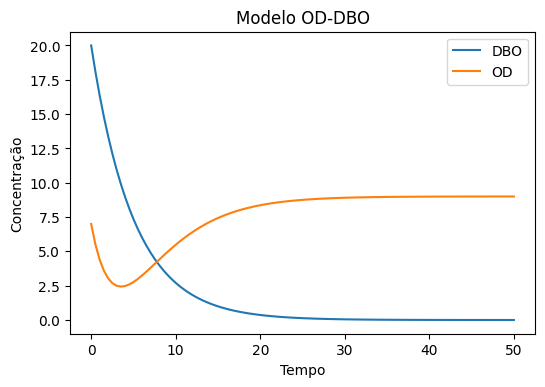

In [3]:
# Modelagem OD-DBO

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def odes(x, t):
    global Os

    kd = 0.2
    ka = 0.3

    L = x[0]
    O = x[1]

    dLdt = -kd * L
    dOdt = -kd * L + ka * (Os - O)

    return dLdt, dOdt


L0 = 20
O0 = 7
Os = 9

x0 = [L0, O0]

t = np.linspace(0, 50, 100)

x = odeint(odes, x0, t)

L = x[:, 0]
O = x[:, 1]

plt.figure(dpi=100)
plt.title("Modelo OD-DBO")
plt.plot(t, L, label="DBO")
plt.plot(t, O, label="OD")
plt.xlabel("Tempo")
plt.ylabel("Concentração")
plt.legend(loc="best")
plt.show()

# Modelagem do ciclo do nitrogênio

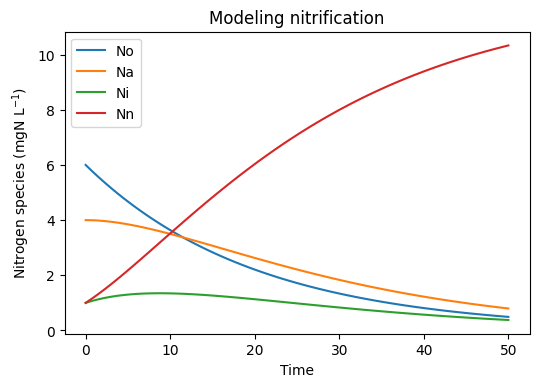

In [4]:
# Modelagem nitrificação (CHAPRA, p. 426)
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def odes(x, t):
    # The subscripts o, a, i, and n denote organic, ammonium, nitrite,
    # and nitrate, respectively.
    kin = 0.2  # 0.75 d-1
    kai = 0.075  # d-1
    koa = 0.05  # d-1
    roa = 3.43  # gO gN-1
    roi = 1.14  # gO gN-1
    ron = roa + roi  # gO gN-1

    # Chute:
    ka = 0.1  # d-1
    Ni = 3  # mg L-1
    D = 1

    No = x[0]
    Na = x[1]
    Ni = x[2]
    Nn = x[3]

    dNodt = -koa * No
    dNadt = koa * No - kai * Na
    dNidt = kai * Na - kin * Ni
    dNndt = kin * Ni

    # An oxygen deficit balance can be written as:
    dDdt = roa * kai * Na + roi * kin * Ni - ka * D

    return dNodt, dNadt, dNidt, dNndt, dDdt


No0 = 6
Na0 = 4
Ni0 = 1
Nn0 = 1
D0 = 1

x0 = [No0, Na0, Ni0, Nn0, D0]

t = np.linspace(0, 50, 100)

x = odeint(odes, x0, t)

No = x[:, 0]
Na = x[:, 1]
Ni = x[:, 2]
Nn = x[:, 3]
D = x[:, 4]

plt.figure(dpi=100)
plt.title("Modeling nitrification")
plt.plot(t, No, label="No")
plt.plot(t, Na, label="Na")
plt.plot(t, Ni, label="Ni")
plt.plot(t, Nn, label="Nn")
# plt.plot(t, D,  label='D')
plt.xlabel("Time")
plt.ylabel("Nitrogen species ($\mathrm{mgN~L}^{- 1}$)")
plt.legend(loc="best")
plt.show()

# O próximo gráfico seria DO (mg L-1) pelo Time, plotando as variáveis
# 'Nitrification model' e 'NBOD'
